<a href="https://colab.research.google.com/github/abhibrat/micrograd/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

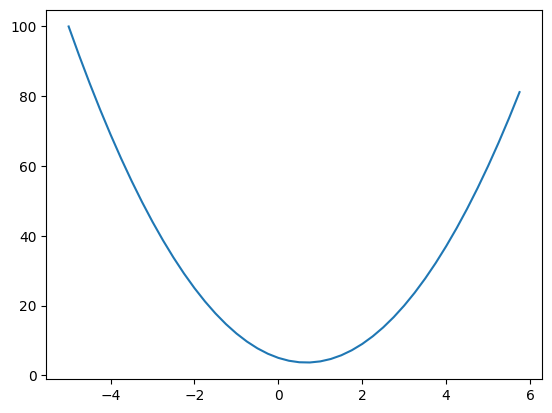

In [ ]:
xs = np.arange(-5,6,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [ ]:
h=0.000001
x=2/3
(f(x+h)-f(x))/h

2.999378523327323e-06

In [ ]:
def f(a,b,c):
  d= a*b +c
  return d

a = 2.0
b= -3.0
c = 10.0

print(f(a,b,c))

4.0


In [ ]:
h=0.00000001

# inputs
a = 2.0
b= -3.0
c = 10.0

y1= f(a,b,c)
y2= f(a,b,c+h)

print('y1',y1)
print('y2',y2)
print('slope', (y2-y1)/h)


y1 4.0
y2 4.000000010000001
slope 1.000000082740371


In [19]:
class Value:

  def __init__(self, data, _prev=(), _op='', label=''):
    self.data = data
    self._prev = set(_prev)
    self._op = _op
    self.label = label
    self.grad = 0.0
    self._backward = lambda: None

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, _prev=(self, other), _op='+')

    def _backward():
      self.grad += out.grad
      other.grad += out.grad
    out._backward = _backward

    return out

  def __radd__(self,other):
    return self.__add__(other)

  def __mul__(self,other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, _prev=(self, other), _op='*')

    def _backward():
      self.grad += out.grad*other.data
      other.grad += out.grad*self.data
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self.__mul__(other)

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __rsub__(self, other):
    return self.__sub__(other)

  def __pow__(self, other):
    other = other if isinstance(other, (int, float)) else other.data
    out = Value(self.data**other, _prev=(self,), _op=f'**{other}')

    def _backward():
      self.grad += other*(self.data**(other-1))*out.grad

    out._backward = _backward
    return out

  def __truediv__(self, other):
    return self.__mul__(other.pow(-1))

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, _prev=(self,), _op='tanh')

    def _backward():
      self.grad += out.grad*(1-out.data**2)

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), _prev=(self,), _op='exp')

    def _backward():
      self.grad += out.grad*out.data
    out._backward = _backward

    return out


  def backward(self):
    topo=[]
    visited = set()
    def toposort(node):
      if node in visited:
        return
      visited.add(node)
      for x in node._prev:
        toposort(x)
      topo.append(node)

    toposort(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




In [5]:
from graphviz import Digraph
def draw(root):
  g= Digraph(format='svg', graph_attr={'rankdir':'LR'})
  visited=set()
  def build(node: Value, successor=None):
    # if node in visited:
    #   return
    # visited.add(node)
    g.node(name=str(id(node)), label="{%s | data %0.4f | grad %0.4f}" %(node.label, node.data, node.grad), shape='record')
    if successor and successor._op:
      g.edge(str(id(node)), str(id(successor))+successor._op)

    if node in visited:
      return
    visited.add(node)

    if node._op:
      g.node(name=str(id(node))+node._op, label=node._op)
      g.edge(str(id(node))+node._op, str(id(node)))

    for x in node._prev:
      build(x, node)
  build(root)
  return g



In [ ]:
a=Value(-3.0, label='a')
b=Value(2.0, label='b')
c=Value(10.0, label='c')
e=a*b; e.label='e'
d=e+c; d.label='d'
f = Value(-2.0, label='f')
L= d*f; L.label='L'


{Value(data=-6.0), Value(data=10.0)} +


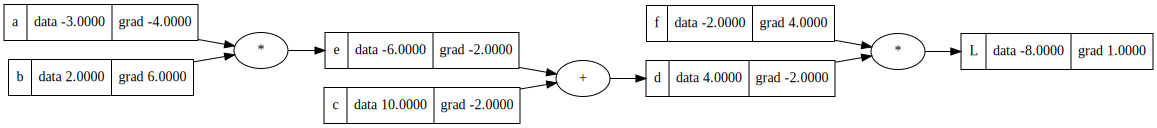

In [ ]:
draw(L)

In [ ]:
def lol():
  a=Value(-3.0, label='a')
  b=Value(2.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f = Value(-2.0, label='f')
  L1= d*f; L.label='L'

  h=0.001

  a=Value(-3.0, label='a')
  b=Value(2.0+h, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'

  d=e+c; d.label='d'

  f = Value(-2.0, label='f')
  L2= d*f ; L.label='L'

  print((L2.data-L1.data)/h)

lol()

6.000000000000227


In [ ]:
L.grad = 1
f.grad = 4
d.grad = -2
e.grad = -2
c.grad = -2

# dL/de* de/da = -2*2 = -4
a.grad = -4
b.grad= 6

In [ ]:
a.data+=0.01*a.grad
b.data+=0.01*b.grad
c.data+=0.01*c.grad
f.data+=0.01*f.grad
# b=Value(2.0, label='b')
# c=Value(10.0, label='c')
e = a*b;
d = e+c;

L= d*f;
print(L.data)

-6.728799999999996


In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# w3 = Value(6.0, label='w3')
#bias of the neuron
b=Value(6.881373, label='b')

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# x1w3 = x1*w3; x1w3.label = 'x1w3'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# y = x1w1x2w2+ x1w3; y.label = 'y'
n = x1w1x2w2 + b; n.label='n'
# n = y+b;n.label='n'

o = n.tanh(); o.label = 'o'



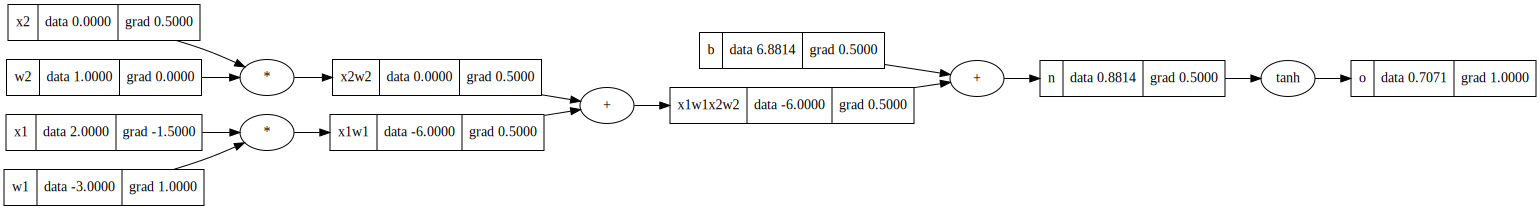

In [ ]:
draw(o)

In [ ]:
o.backward()


In [ ]:
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
w1._backward()
w2._backward()
b._backward()

In [ ]:
o.grad = 1
n.grad = 1-o.data**2
b.grad = n.grad
x1w1x2w2.grad = n.grad
x1w1.grad = n.grad
x2w2.grad = n.grad
w1.grad = x1.data * x1w1.grad
w2.grad = x2.data * x2w2.grad
x2.grad = w2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad

In [ ]:
1-o.data**2

0.6347395899824584

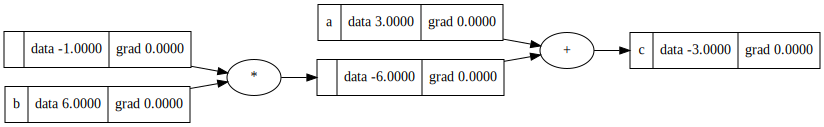

In [ ]:
a = Value(3.0); a.label='a'
b = Value(6.0); b.label='b'
c= a-b ; c.label='c'
# d= a*c; d.label='d'
draw(c)

In [ ]:
#inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# w3 = Value(6.0, label='w3')
#bias of the neuron
b=Value(6.881373, label='b')

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# x1w3 = x1*w3; x1w3.label = 'x1w3'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# y = x1w1x2w2+ x1w3; y.label = 'y'
n = x1w1x2w2 + b; n.label='n'
# n = y+b;n.label='n'

e = (2*n).exp(); e.label = 'e'
o = (e -1) / (e +1); o.label = 'o'

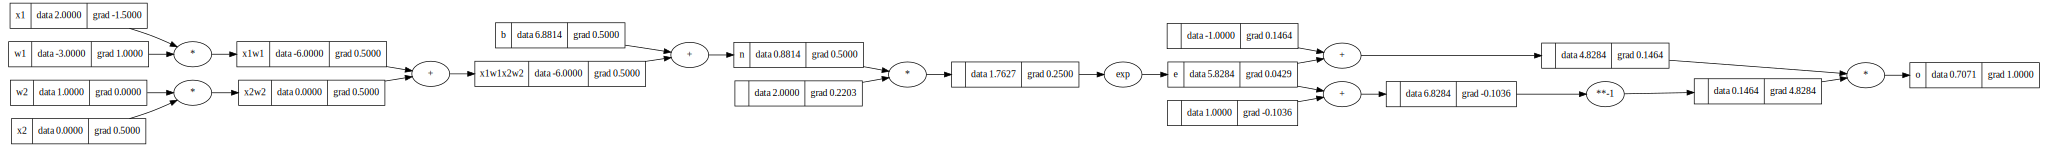

In [ ]:
o.backward()
draw(o)

In [ ]:
# #### IN PYTORCH
import torch

In [ ]:
x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.881373]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())

0.7071064519863152
---
x1 -1.500001396677975
w1 1.00000093111865
x2 0.500000465559325
w2 0.0


In [36]:
#### Neural Network
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for i in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
    out =  act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params.extend(neuron.parameters())
    return params

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin]+ nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      params.extend(layer.parameters())
    return params




In [42]:
x= [2.0, 3.0]
o = MLP(2,[3,4,1])
# o(x)
ans=o(x)
ans
len(o.parameters())

30

In [ ]:
draw(ans)

In [ ]:
ans.backward()

In [75]:
n = MLP(3,[4,4,1])

In [76]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] #desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8106241639903276),
 Value(data=0.4831042664147071),
 Value(data=0.5576522501895768),
 Value(data=0.7327695158725065)]

In [68]:
loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.402613620653836)

In [45]:
loss.backward()

In [46]:
n.layers[0].neurons[0].w[0].grad

0.18854756841533948

In [51]:
n.layers[0].neurons[0].w[0].data += 0.01* -(n.layers[0].neurons[0].w[0].grad)


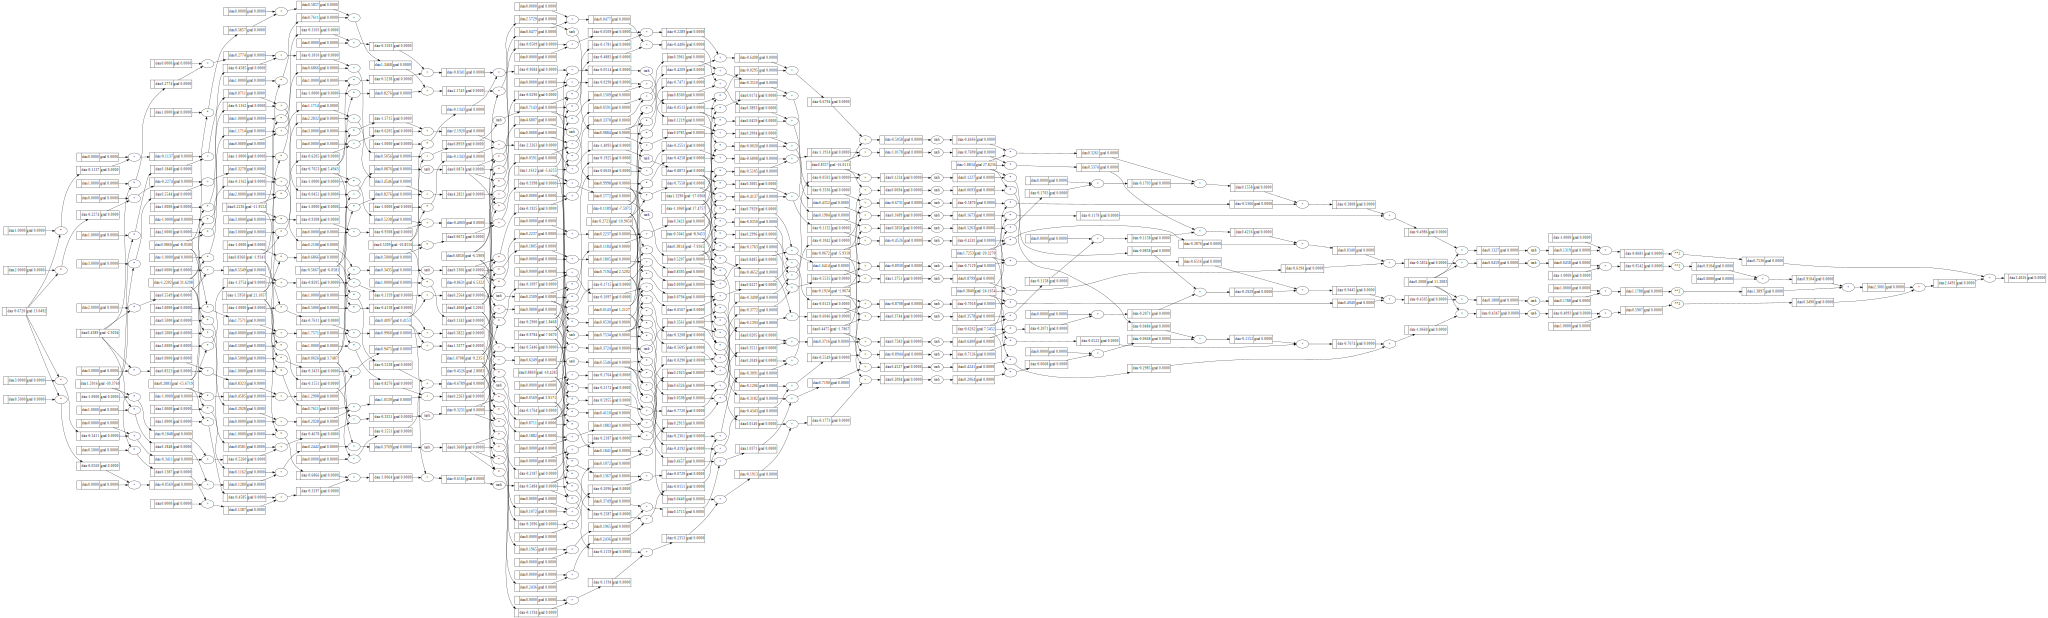

In [88]:
draw(loss)

In [85]:
step = 0.05
def train():
  for i in range(50):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
    print(loss)

    #backward pass
    for param in n.parameters():
      param.grad = 0.0 #reset the grads to 0
    loss.backward()

    #gradient descent
    for param in n.parameters():
      param.data += step*(-param.grad)


In [53]:
loss.backward()

In [86]:
train()

Value(data=0.01023651875136937)
Value(data=0.010084600154947308)
Value(data=0.009937019920796514)
Value(data=0.009793596462585805)
Value(data=0.009654158145400934)
Value(data=0.009518542614821256)
Value(data=0.009386596179483165)
Value(data=0.009258173242224095)
Value(data=0.009133135775409685)
Value(data=0.009011352836493972)
Value(data=0.008892700120262295)
Value(data=0.008777059544559193)
Value(data=0.008664318866617875)
Value(data=0.008554371327389192)
Value(data=0.008447115321515803)
Value(data=0.008342454090822918)
Value(data=0.00824029543939437)
Value(data=0.008140551468483559)
Value(data=0.00804313832966736)
Value(data=0.007947975994797348)
Value(data=0.007854988041430172)
Value(data=0.007764101452536826)
Value(data=0.007675246429395993)
Value(data=0.007588356216669874)
Value(data=0.007503366938749036)
Value(data=0.007420217446528699)
Value(data=0.007338849173849342)
Value(data=0.007259206002899044)
Value(data=0.007181234137932438)
Value(data=0.007104881986712747)
Value(data=0.

In [87]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.9689075931603227),
 Value(data=-0.9724059744760931),
 Value(data=-0.9525053658387309),
 Value(data=0.957351981805067)]